# Libraries

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [3]:
df = pd.read_csv(r'K:\Projects\misc\data\jena_climate_2009_2016.csv')

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Details

* An observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.
* For 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

## Data prep

In [6]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [30]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices].values, (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

# Univariate

Only using temperature to predict

In [23]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020628FC1160>],
      dtype=object)

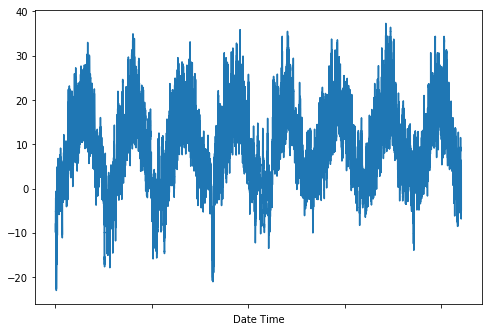

In [24]:
uni_data.plot(subplots=True)


In [25]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [26]:
uni_data = (uni_data-uni_train_mean)/uni_train_std


In [31]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [55]:
i = 0
print ('Single window of past history')
print (x_train_uni[i])
print ('\n Target temperature to predict')
print (y_train_uni[i])

Single window of past history
[[-1.99765961]
 [-2.04281557]
 [-2.05439402]
 [-2.03123712]
 [-2.02660574]
 [-2.00113315]
 [-1.95134582]
 [-1.95134582]
 [-1.98492332]
 [-2.04513126]
 [-2.08334014]
 [-2.09723428]
 [-2.09376075]
 [-2.09144506]
 [-2.07176169]
 [-2.07176169]
 [-2.07639307]
 [-2.08912937]
 [-2.0926029 ]
 [-2.10418135]]

 Target temperature to predict
-2.1041813528324704


In [56]:
def create_time_steps(length):
    return list(range(-length, 0))

In [57]:
create_time_steps(5)

[-5, -4, -3, -2, -1]

In [58]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'k:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

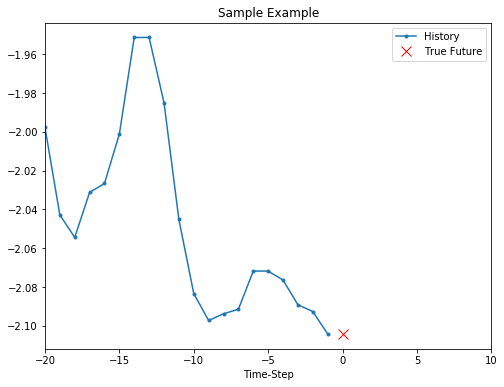

In [59]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


## Baseline

Establishing baseline of only using mean to predict next time step

In [60]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'k:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

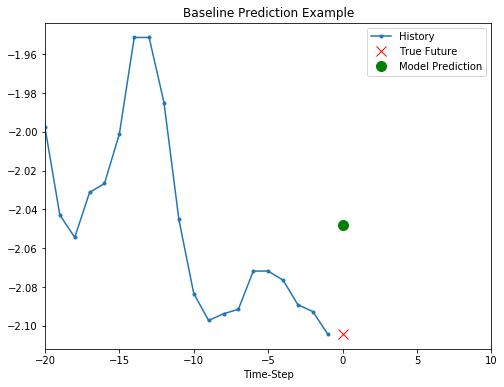

In [62]:
# baseline prediction only using mean
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## LSTM data prep

![](https://www.tensorflow.org/tutorials/structured_data/images/time_series.png)

In [63]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


In [67]:
x_train_uni.shape[-2:]

(20, 1)

## Univariate Model

In [68]:
simple_lstm_model = tf.keras.models.Sequential([
    # input shape to be #samples, timesteps, features
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [70]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [71]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 39ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [===========================

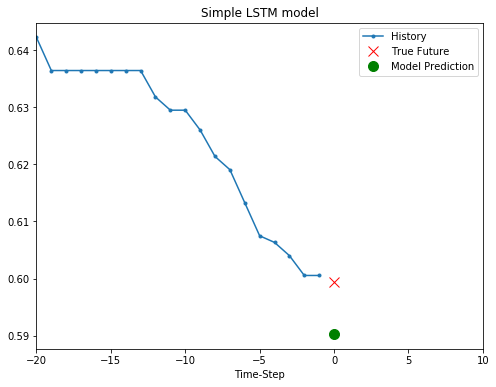

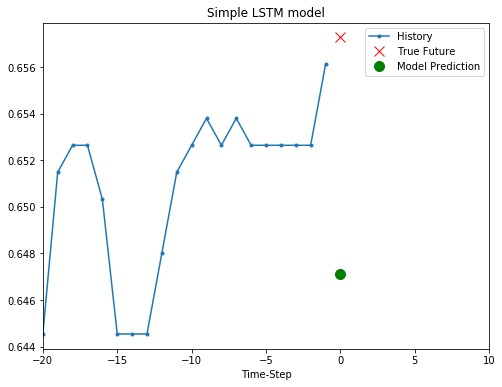

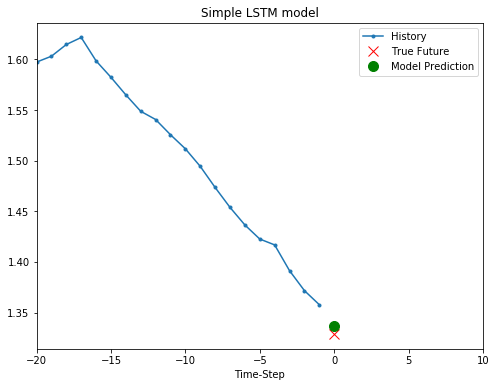

In [72]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# Multivariate

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

To use more features, add their names to this list.

In [73]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [75]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [76]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002062C99BB00>,
      dtype=object)

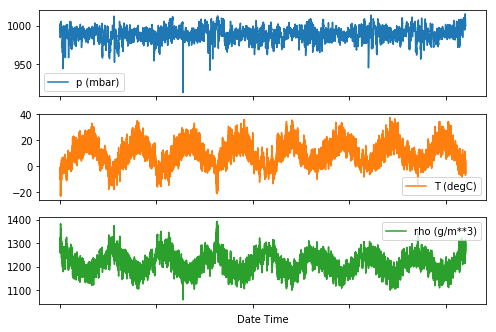

In [77]:
features.plot(subplots=True)


## Data prep

* Normalize data using standard scaling
* Sampling at every hour, 6 points and sample one
* then pick at 12 hours in the future 6*12 = 72 points after
* In short, use every other 60 points of 5 points to predict 1 point after 72 points

In [78]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [79]:
dataset = (dataset-data_mean)/data_std

In [116]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [117]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [119]:
x_train_single[0]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01982895, -2.13776242,  2.40317953],
       [ 1.06597053, -2.18870768,  2.46997927],
       [ 1.11211211, -2.17944491,  2.47218146],
       [ 1.1958955 , -2.07755438,  2.38482796],
       [ 1.28939291, -2.01155711,  2.33858199],
       [ 1.35253402, -1.96176969,  2.3026129 ],
       [ 1.43024615, -1.8830361 ,  2.2389941 ],
       [ 1.47638773, -1.93513921,  2.30750665],
       [ 1.40353261, -1.85293208,  2.20033345],
       [ 1.37439056, -1.74409447,  2.07921305],
       [ 1.35496252, -1.74525232,  2.07407461],
       [ 1.37560481, -1.70935906,  2.04128646],
       [ 1.38410457, -1.68388643,  2.01632831],
       [ 1.3986756 , -1.6977806 ,  2.03565864],
       [ 1.39381859, -1.66651873,  2.00164705],
       [ 1.41446088, -1.63641471,  1.97448672],
       [ 1.41081812, -1.63988825,  1.978

In [125]:
dataset[ : : 6][:120]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01982895, -2.13776242,  2.40317953],
       [ 1.06597053, -2.18870768,  2.46997927],
       [ 1.11211211, -2.17944491,  2.47218146],
       [ 1.1958955 , -2.07755438,  2.38482796],
       [ 1.28939291, -2.01155711,  2.33858199],
       [ 1.35253402, -1.96176969,  2.3026129 ],
       [ 1.43024615, -1.8830361 ,  2.2389941 ],
       [ 1.47638773, -1.93513921,  2.30750665],
       [ 1.40353261, -1.85293208,  2.20033345],
       [ 1.37439056, -1.74409447,  2.07921305],
       [ 1.35496252, -1.74525232,  2.07407461],
       [ 1.37560481, -1.70935906,  2.04128646],
       [ 1.38410457, -1.68388643,  2.01632831],
       [ 1.3986756 , -1.6977806 ,  2.03565864],
       [ 1.39381859, -1.66651873,  2.00164705],
       [ 1.41446088, -1.63641471,  1.97448672],
       [ 1.41081812, -1.63988825,  1.978

In [129]:
dataset[792, :]

array([ 1.10239809, -2.74331635,  3.09026253])

In [128]:
y_train_single[0]

-2.743316352505301

In [130]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 3)


## Single step prediction

In [131]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [132]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [133]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [134]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 65s 324ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 73s 366ms/step - loss: 0.2625 - val_loss: 0.2432
Epoch 3/10
200/200 [==============================] - 92s 459ms/step - loss: 0.2614 - val_loss: 0.2476
Epoch 4/10
200/200 [==============================] - 117s 584ms/step - loss: 0.2566 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 144s 722ms/step - loss: 0.2267 - val_loss: 0.2360
Epoch 6/10
200/200 [==============================] - 172s 860ms/step - loss: 0.2413 - val_loss: 0.2667
Epoch 7/10
200/200 [==============================] - 183s 916ms/step - loss: 0.2414 - val_loss: 0.2577
Epoch 8/10
200/200 [==============================] - 193s 966ms/step - loss: 0.2407 - val_loss: 0.2371
Epoch 9/10
200/200 [==============================] - 179s 893ms/step - loss: 0.2447 - val_loss: 0.2486
Epoch 10/10
200/200 [===

In [135]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

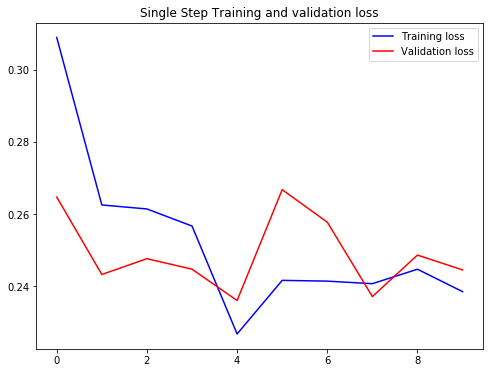

In [136]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

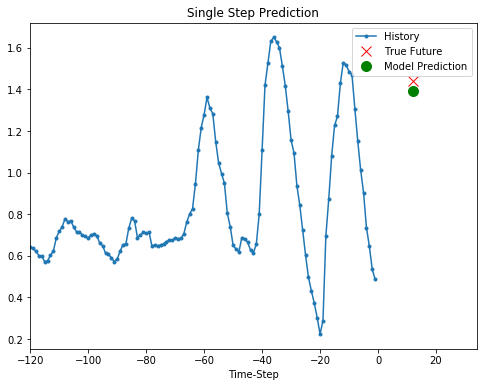

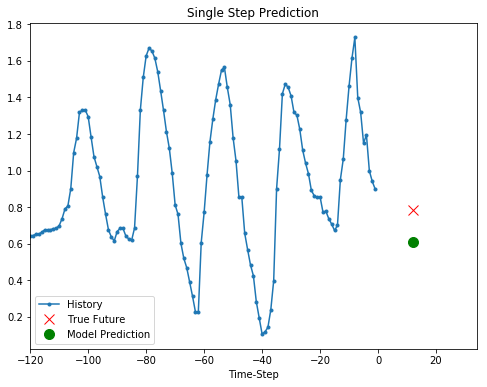

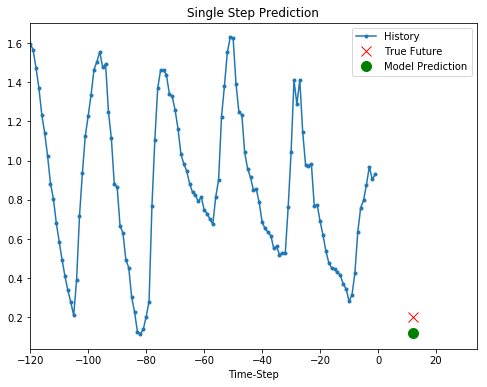

In [137]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

## Multi-step prediction

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

* Sample every 6 points up to 120 points
* Predict the next 72 points

In [138]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [139]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [155]:
x_train_multi[0]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01982895, -2.13776242,  2.40317953],
       [ 1.06597053, -2.18870768,  2.46997927],
       [ 1.11211211, -2.17944491,  2.47218146],
       [ 1.1958955 , -2.07755438,  2.38482796],
       [ 1.28939291, -2.01155711,  2.33858199],
       [ 1.35253402, -1.96176969,  2.3026129 ],
       [ 1.43024615, -1.8830361 ,  2.2389941 ],
       [ 1.47638773, -1.93513921,  2.30750665],
       [ 1.40353261, -1.85293208,  2.20033345],
       [ 1.37439056, -1.74409447,  2.07921305],
       [ 1.35496252, -1.74525232,  2.07407461],
       [ 1.37560481, -1.70935906,  2.04128646],
       [ 1.38410457, -1.68388643,  2.01632831],
       [ 1.3986756 , -1.6977806 ,  2.03565864],
       [ 1.39381859, -1.66651873,  2.00164705],
       [ 1.41446088, -1.63641471,  1.97448672],
       [ 1.41081812, -1.63988825,  1.978

In [144]:
dataset[ : : 6][:120]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01982895, -2.13776242,  2.40317953],
       [ 1.06597053, -2.18870768,  2.46997927],
       [ 1.11211211, -2.17944491,  2.47218146],
       [ 1.1958955 , -2.07755438,  2.38482796],
       [ 1.28939291, -2.01155711,  2.33858199],
       [ 1.35253402, -1.96176969,  2.3026129 ],
       [ 1.43024615, -1.8830361 ,  2.2389941 ],
       [ 1.47638773, -1.93513921,  2.30750665],
       [ 1.40353261, -1.85293208,  2.20033345],
       [ 1.37439056, -1.74409447,  2.07921305],
       [ 1.35496252, -1.74525232,  2.07407461],
       [ 1.37560481, -1.70935906,  2.04128646],
       [ 1.38410457, -1.68388643,  2.01632831],
       [ 1.3986756 , -1.6977806 ,  2.03565864],
       [ 1.39381859, -1.66651873,  2.00164705],
       [ 1.41446088, -1.63641471,  1.97448672],
       [ 1.41081812, -1.63988825,  1.978

In [148]:
y_train_multi[0]

array([-2.54879807, -2.56616578, -2.58121779, -2.59048056, -2.60205903,
       -2.6136375 , -2.61942673, -2.62405812, -2.6310052 , -2.64258367,
       -2.64605721, -2.64837291, -2.6506886 , -2.66110922, -2.66689846,
       -2.67268769, -2.67500338, -2.67731908, -2.6877397 , -2.69931817,
       -2.71089664, -2.7247908 , -2.72015941, -2.72363296, -2.73521142,
       -2.7444742 , -2.75952621, -2.77457822, -2.79426162, -2.8208921 ,
       -2.82899702, -2.82436564, -2.83478626, -2.84173334, -2.83941765,
       -2.84868042, -2.86257458, -2.89036291, -2.95751803, -3.00151621,
       -3.00383191, -3.02119961, -3.02814669, -3.025831  , -3.02467315,
       -3.03393593, -3.03972516, -3.02814669, -2.9517288 , -2.9320454 ,
       -2.92394047, -2.91930908, -2.91004631, -2.88804722, -2.88573152,
       -2.86720597, -2.81394501, -2.83478626, -2.8556275 , -2.83247056,
       -2.8185764 , -2.81973425, -2.81278717, -2.81047147, -2.82204994,
       -2.81162932, -2.77226253, -2.77689391, -2.77342037, -2.76

In [149]:
dataset[ : : 6][:120]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01982895, -2.13776242,  2.40317953],
       [ 1.06597053, -2.18870768,  2.46997927],
       [ 1.11211211, -2.17944491,  2.47218146],
       [ 1.1958955 , -2.07755438,  2.38482796],
       [ 1.28939291, -2.01155711,  2.33858199],
       [ 1.35253402, -1.96176969,  2.3026129 ],
       [ 1.43024615, -1.8830361 ,  2.2389941 ],
       [ 1.47638773, -1.93513921,  2.30750665],
       [ 1.40353261, -1.85293208,  2.20033345],
       [ 1.37439056, -1.74409447,  2.07921305],
       [ 1.35496252, -1.74525232,  2.07407461],
       [ 1.37560481, -1.70935906,  2.04128646],
       [ 1.38410457, -1.68388643,  2.01632831],
       [ 1.3986756 , -1.6977806 ,  2.03565864],
       [ 1.39381859, -1.66651873,  2.00164705],
       [ 1.41446088, -1.63641471,  1.97448672],
       [ 1.41081812, -1.63988825,  1.978

In [152]:
dataset[720:792, 1]

array([-2.54879807, -2.56616578, -2.58121779, -2.59048056, -2.60205903,
       -2.6136375 , -2.61942673, -2.62405812, -2.6310052 , -2.64258367,
       -2.64605721, -2.64837291, -2.6506886 , -2.66110922, -2.66689846,
       -2.67268769, -2.67500338, -2.67731908, -2.6877397 , -2.69931817,
       -2.71089664, -2.7247908 , -2.72015941, -2.72363296, -2.73521142,
       -2.7444742 , -2.75952621, -2.77457822, -2.79426162, -2.8208921 ,
       -2.82899702, -2.82436564, -2.83478626, -2.84173334, -2.83941765,
       -2.84868042, -2.86257458, -2.89036291, -2.95751803, -3.00151621,
       -3.00383191, -3.02119961, -3.02814669, -3.025831  , -3.02467315,
       -3.03393593, -3.03972516, -3.02814669, -2.9517288 , -2.9320454 ,
       -2.92394047, -2.91930908, -2.91004631, -2.88804722, -2.88573152,
       -2.86720597, -2.81394501, -2.83478626, -2.8556275 , -2.83247056,
       -2.8185764 , -2.81973425, -2.81278717, -2.81047147, -2.82204994,
       -2.81162932, -2.77226253, -2.77689391, -2.77342037, -2.76

In [153]:
y_train_multi[0]

array([-2.54879807, -2.56616578, -2.58121779, -2.59048056, -2.60205903,
       -2.6136375 , -2.61942673, -2.62405812, -2.6310052 , -2.64258367,
       -2.64605721, -2.64837291, -2.6506886 , -2.66110922, -2.66689846,
       -2.67268769, -2.67500338, -2.67731908, -2.6877397 , -2.69931817,
       -2.71089664, -2.7247908 , -2.72015941, -2.72363296, -2.73521142,
       -2.7444742 , -2.75952621, -2.77457822, -2.79426162, -2.8208921 ,
       -2.82899702, -2.82436564, -2.83478626, -2.84173334, -2.83941765,
       -2.84868042, -2.86257458, -2.89036291, -2.95751803, -3.00151621,
       -3.00383191, -3.02119961, -3.02814669, -3.025831  , -3.02467315,
       -3.03393593, -3.03972516, -3.02814669, -2.9517288 , -2.9320454 ,
       -2.92394047, -2.91930908, -2.91004631, -2.88804722, -2.88573152,
       -2.86720597, -2.81394501, -2.83478626, -2.8556275 , -2.83247056,
       -2.8185764 , -2.81973425, -2.81278717, -2.81047147, -2.82204994,
       -2.81162932, -2.77226253, -2.77689391, -2.77342037, -2.76

In [156]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [157]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [159]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

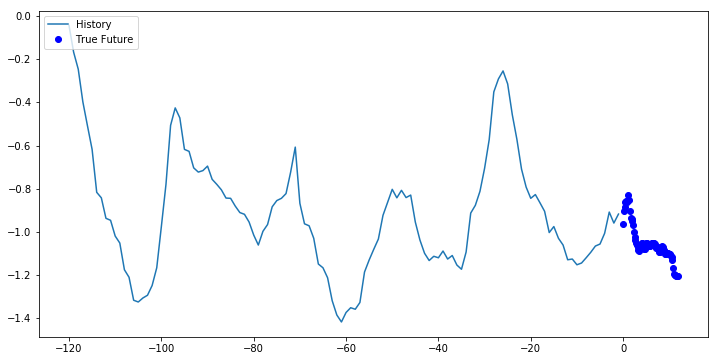

In [160]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [161]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

# output 72 points ahead
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [162]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [163]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 380s 2s/step - loss: 0.4974 - val_loss: 0.3019
Epoch 2/10
200/200 [==============================] - 308s 2s/step - loss: 0.3480 - val_loss: 0.2845
Epoch 3/10
200/200 [==============================] - 345s 2s/step - loss: 0.3335 - val_loss: 0.2523
Epoch 4/10
200/200 [==============================] - 415s 2s/step - loss: 0.2438 - val_loss: 0.2093
Epoch 5/10
200/200 [==============================] - 422s 2s/step - loss: 0.1962 - val_loss: 0.2025
Epoch 6/10
200/200 [==============================] - 481s 2s/step - loss: 0.2062 - val_loss: 0.2108
Epoch 7/10
200/200 [==============================] - 535s 3s/step - loss: 0.1981 - val_loss: 0.2047
Epoch 8/10
200/200 [==============================] - 532s 3s/step - loss: 0.1965 - val_loss: 0.1983
Epoch 9/10
200/200 [==============================] - 537s 3s/step - loss: 0.2001 - val_loss: 0.1873
Epoch 10/10
200/200 [===========================

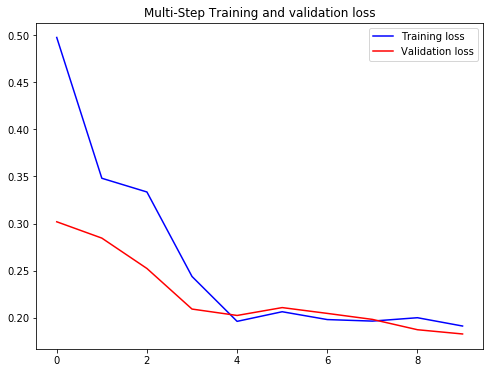

In [164]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


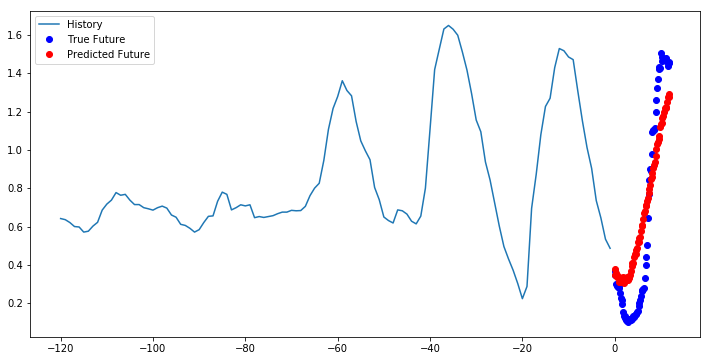

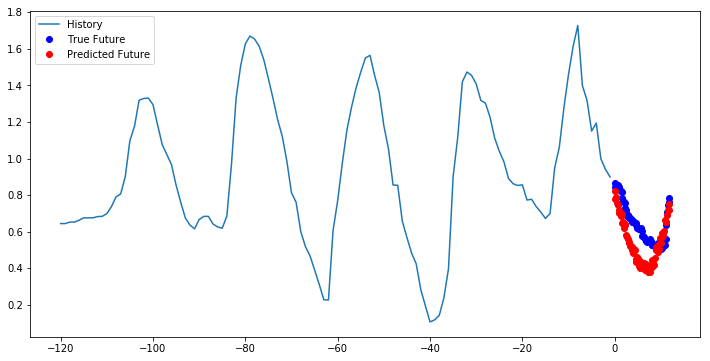

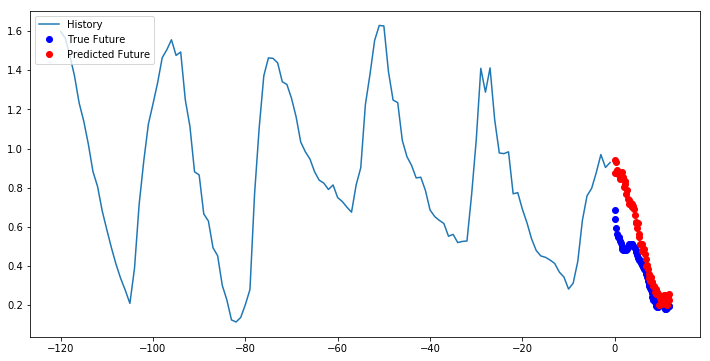

In [165]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])